\begin{align*}
p_{* \dagger}(x) & \quad = \quad \exp(-7.85785 + 0.01538 x + 0.000577355 x^2)\\
p_{* \diamondsuit_{1}}(x) & \quad = \quad 3\cdot 10^{-4} \cdot (8.4764-1.0985x + 0.055x^2)\\
p_{\diamondsuit_{k} \dagger}(x) & \quad = \quad p_{* \dagger}(x) + 0.008\\
p_{\diamondsuit_{k} *}(x) & \quad = \quad \left \{ \array{ \exp(-0.94(k-1)) \cdot \alpha(x, k), &\text{for } k < 8 \\ 0, & \text{otherwise}} \right.\\
\alpha(x,k) & \quad = \quad \max(0,0.773763-0.01045(x-k + 1))\\
\end{align*}

In [43]:
# Start age of insurance
x0 = 20
# End age ie last payment in period [s-1,s[
xend = 65
# Interest Rate
interestrate = 0.02
# Annual Annuity
annuity = 12000.

In [44]:
import numpy as np

# Mortality for healthy at age x
def mua(x):
    return(np.exp(-7.85785 + 0.01538*x + 0.000577355*x**2))

# Mortality for disabled at age x
def mui(x):
    return(mua(x)+0.008)

#Probability to become disabled at age x
def sigma(x):
    return(3.e-4 * (8.4764-1.0985*x + 0.055*x**2))

def alpha(x,k):
    return(max(0,0.773763-0.01045*(x - k + 1)))
# Reactivation probability for state \diamondsuit_k and age x
def rx(x,k,foreversick):
    if (k>= foreversick): return(0.)
    return(np.exp(-0.94*(k-1)) * alpha(x, k))

def stayhealty(x):
    return 1 - mua(x) - sigma(x)

def staysick(x, status, foreversick):
    return 1 - mui(x) - rx(x, status, foreversick)

In [45]:
#Probability stay healty 25-65
def alwayshealty(n):
    if (n < 25): raise ValueError('the age has to be between 25 and 65 years')
    if (n == 25): return 1
    return alwayshealty(n-1) - mua(n - 1) - mui(n - 1)

In [46]:
a = alwayshealty(65)
print(a)

0.3996904441523529


In [55]:
# Thiele's equation

class Thiele():
    
    def __init__(self):
        self.stati = {}
        self.healthy = 0
        self.firstsick = 1
        self.foreversick = 8
        self.dead = self.foreversick + 1
        self.sicknessrange = range(1, self.dead)
        
    def alreadycalculated(self, n, status):
        retrieved = self.stati.get(n)
        if (retrieved == None): return False
        else: return (retrieved.get(status) != None)
    
    def save(self, n, status, res):
        retrieved = self.stati.get(n)
        if (retrieved == None): self.stati[n] = {}
        self.stati[n][status] = res
        
        
    def prepayment(self, n, status):
        if (status == self.healthy or status == self.dead):
            return 0.
        elif (status in self.sicknessrange):
            return annuity
        else:
            raise ValueError('The status given for the prepayment is not contemplated')

    def postpayment(self, n, status, newstatus):
        return 0.

    def transitionprobability(self, n, status, newstatus):
            if (status == self.healthy):
                if (newstatus == self.healthy): return stayhealty(n)
                elif (newstatus == self.firstsick): return sigma(n)
                elif (newstatus == self.dead): return mua(n)
                else: return 0.
            elif (status in self.sicknessrange):
                if (newstatus == self.dead): return mui(n)
                elif (newstatus == self.healthy): return rx(n, status, self.foreversick)
                elif (newstatus == status + 1): return staysick(n, status, self.foreversick)
                else: return 0.
            elif (status == self.dead):
                if (newstatus == self.dead): return 1.
                else: return 0.               
            else:
                raise ValueError('The status given for the transition probability is not contemplated')

    def reserves(self, n, status):
        if (n == xend): return 0.
        if (status == self.dead): return 0.
        if self.alreadycalculated(n, status): return self.stati[n][status]
        interest = 1/(1 + interestrate)
        subsequent = 0
        for newstatus in range(self.dead + 1):
            tp = self.transitionprobability(n, status, newstatus)
            if tp > 0:
                subsequent += tp * (self.postpayment(n, status, newstatus) + self.reserves(n+1, newstatus))
        res = self.prepayment(n, status) + interest * subsequent
        self.save(n, status, res)
        return self.prepayment(n, status) + interest * subsequent
            

In [56]:
c = Thiele()
c.reserves(20, 0)
print(c.stati[20][0])

19444.154343551483


In [57]:
c = Thiele()
c.reserves(x0, 0)
ages = [i for i in range(x0, xend)]
rsvs = [c.reserves(j, 0) for j in ages]

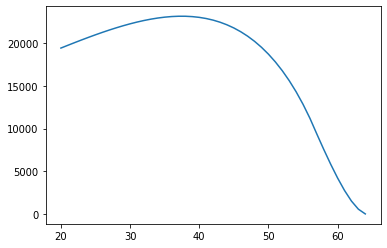

In [58]:
import matplotlib.pyplot as plt

plt.plot(ages, rsvs)
plt.show()

In [59]:
t = Thiele()
agest = [i for i in range(x0, xend)]
tr = [c.transitionprobability(j, min(c.foreversick, (j - x0) % 10 + 1), 0) for j in agest]

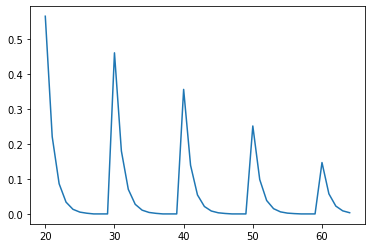

In [60]:
plt.plot(agest, tr)
plt.show()